In [1]:
import sys
print(sys.version)
print(spark.version)

3.8.15 | packaged by conda-forge | (default, Nov 22 2022, 08:46:39) 
[GCC 10.4.0]
3.1.3


In [2]:
import os
import time
import subprocess

from pyspark.sql.functions import *
from pyspark.sql.types import *

from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

In [3]:
warnings.filterwarnings(action='ignore')
spark = SparkSession.builder.getOrCreate()

##Add "eagerEval.enabled" to beautify the way Spark DF is displayed
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

## To use legacy casting notation for date
spark.conf.set("spark.sql.legacy.timeParserPolicy","LEGACY")

In [4]:
filtered=spark.read.parquet('gs://msca-bdp-students-bucket/shared_data/sirivanth/new_filtered')

23/03/08 00:55:21 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [5]:
#filtered.count()

In [6]:
filtered.limit(5).toPandas()

,coordinates,created_at,display_text_range,entities,extended_entities,extended_tweet,favorite_count,favorited,filter_level,geo,...,retweeted_from,retweeted_status,source,text,timestamp_ms,truncated,tweet_text,user,withheld_in_countries,stripped
0,None,Mon Aug 08 20:46:27 +0000 2022,None,"([], [(Row(description=None, embeddable=None, ...","([(Row(description=None, embeddable=None, mone...",None,0,False,low,None,...,asIiceofhistory,"(None, Sun Aug 07 00:18:24 +0000 2022, [0, 27]...","<a href=""https://mobile.twitter.com"" rel=""nofo...","RT @asIiceofhistory: High school students, 198...",1659991587826,False,"high school students, 1989. https://t.co/p3trb...","(False, Fri Mar 09 07:23:12 +0000 2018, False,...",None,high school students 1989
1,None,Mon Aug 08 20:46:28 +0000 2022,None,"([], None, [], [], [(1151504814397960194, 1151...",None,None,0,False,low,None,...,puyogho,"(None, Sun Aug 07 17:11:53 +0000 2022, None, (...","<a href=""http://twitter.com/download/android"" ...",RT @puyogho: Yeah yeah fanart is not allowed i...,1659991588380,False,yeah yeah fanart is not allowed in college por...,"(False, Tue Aug 10 12:39:44 +0000 2021, True, ...",None,yeah yeah fanart is not allowed in college por...
2,None,Mon Aug 08 20:46:28 +0000 2022,None,"([], [(Row(description=None, embeddable=None, ...","([(Row(description=None, embeddable=None, mone...",None,0,False,low,None,...,FfurryStud,"(None, Sun Aug 07 23:22:34 +0000 2022, [0, 77]...","<a href=""http://twitter.com/download/iphone"" r...",RT @FfurryStud: Sunday stretches with the frat...,1659991588984,False,sunday stretches with the frat college boy! 🤤\...,"(False, Sat Oct 17 10:34:00 +0000 2020, True, ...",None,sunday stretches with the frat college boy! 🤤\...
3,None,Mon Aug 08 20:46:31 +0000 2022,None,"([], None, [], [], [(2862711364, 2862711364, [...",None,None,0,False,low,None,...,Abba_Jalo,"(None, Mon Aug 08 14:47:10 +0000 2022, None, (...","<a href=""http://twitter.com/download/android"" ...",RT @Abba_Jalo: You’d see grown adults with uni...,1659991591258,False,you’d see grown adults with university degrees...,"(False, Fri Jul 26 22:48:38 +0000 2013, True, ...",None,you’d see grown adults with university degrees...
4,None,Mon Aug 08 20:46:33 +0000 2022,"[9, 66]","([], None, [], [], [(20545835, 20545835, [0, 8...",None,None,0,False,low,None,...,None,None,"<a href=""http://twitter.com/download/android"" ...","@newsmax So sad, gosh I was in High School whe...",1659991593025,False,"@newsmax so sad, gosh i was in high school whe...","(False, Tue Apr 19 04:09:04 +0000 2022, True, ...",None,newsmax so sad gosh i was in high school when ...


In [7]:
filtered.createOrReplaceTempView("filtered")

In [8]:
query = '''
select retweeted as Retweeted,
retweeted_status.id as status_id,
retweeted_status.user.screen_name as status_user,
user.screen_name as Profile,
user.verified as user_verified,
user.followers_count as followers,
user.statuses_count as tweets_count
from filtered'''
drop_col = spark.sql(query)

In [9]:
ran = drop_col.withColumn("tweet_type",when(col("status_id").isNull() != True,"retweet").otherwise("tweet")).filter(col('tweet_type') == 'tweet')

In [10]:
ran.createOrReplaceTempView("filtered")

In [11]:
spark.sql('SELECT Profile, max(tweets_count) as total_content FROM filtered GROUP BY Profile ORDER BY total_content DESC LIMIT 10').toPandas()

,Profile,total_content
0,la_patilla,6445536
1,laxradar,4572875
2,tropicalisimany,4362559
3,dogandwinelover,4286192
4,PulpNews,4187042
5,infoitinterno,3754208
6,OccuWorld,3672606
7,isRQN,3516124
8,Salvesayson,3460962
9,Rojname_com,3271951


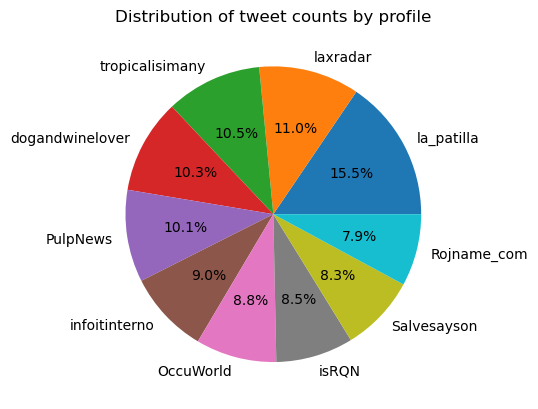

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import SparkSession

# create a SparkSession
spark = SparkSession.builder.appName("PieChart").getOrCreate()

# execute the SQL query and convert the resulting DataFrame to a pandas DataFrame
df = spark.sql('SELECT Profile, max(tweets_count) as total_content FROM filtered GROUP BY Profile ORDER BY total_content DESC LIMIT 10').toPandas()

# create a pie chart using matplotlib
plt.pie(df["total_content"], labels=df["Profile"], autopct='%1.1f%%')
plt.title("Distribution of tweet counts by profile")
plt.show()


In [13]:
spark.sql('SELECT Profile as user, count(*) as original_content FROM filtered WHERE tweet_type = "tweet" GROUP BY user ORDER BY original_content DESC LIMIT 10').toPandas()

,user,original_content
0,EssayPaperUK,6264
1,LoveLiveFrames,5774
2,indiaedudiary,4804
3,AndrianyRahmah,4541
4,group_kq,4541
5,sport9920,2622
6,dederam57977762,2336
7,HBCUSports1,2156
8,ana92479235,2084
9,onepostguy,2077


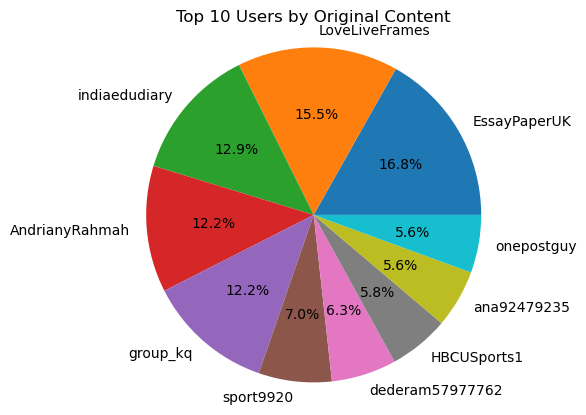

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('Pie Chart Example').getOrCreate()

df = spark.sql('SELECT Profile as user, count(*) as original_content FROM filtered WHERE tweet_type = "tweet" GROUP BY user ORDER BY original_content DESC LIMIT 10').toPandas()

# Create pie chart
plt.pie(df['original_content'], labels=df['user'], autopct='%1.1f%%')
plt.axis('equal')
plt.title('Top 10 Users by Original Content')
plt.show()


In [15]:
ran = drop_col.withColumn("tweet_type",when(col("status_id").isNull() == True,"tweet"))
ran.createOrReplaceTempView("filtered")
ran.count()

24074764

In [16]:
query = '''select Profile, 
count(*) 
from filtered 
where tweet_type = "tweet" 
group by Profile 
order by count(*) 
desc limit 10'''
spark.sql(query).toPandas()

,Profile,count(1)
0,EssayPaperUK,6264
1,LoveLiveFrames,5774
2,indiaedudiary,4804
3,AndrianyRahmah,4541
4,group_kq,4541
5,sport9920,2622
6,dederam57977762,2336
7,HBCUSports1,2156
8,ana92479235,2084
9,onepostguy,2077


In [17]:
spark.sql('select status_user, count(*) from filtered where status_user IS NOT NULL group by status_user order by count(*) desc LIMIT 10').toPandas()

,status_user,count(1)
0,libsoftiktok,126443
1,NasimiShabnam,55607
2,OccupyDemocrats,44228
3,NoLieWithBTC,37775
4,StephenKing,36392
5,AskAnshul,33412
6,RBReich,33358
7,DashDobrofsky,32858
8,ChuckCallesto,31797
9,PeterObi,30803


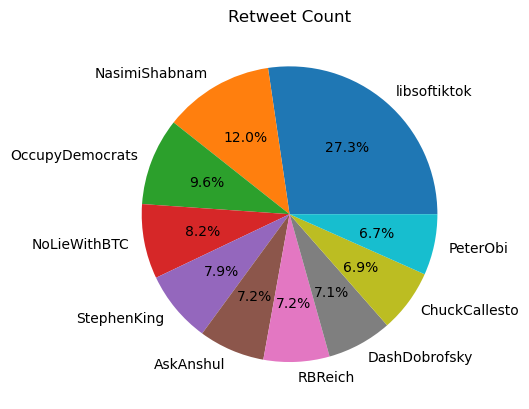

In [18]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import SparkSession

# create a SparkSession
spark = SparkSession.builder.appName("PieChart").getOrCreate()

# execute the SQL query and convert the resulting DataFrame to a pandas DataFrame
df = spark.sql('select status_user, count(*) as count from filtered where status_user IS NOT NULL group by status_user order by count(*) desc LIMIT 10').toPandas()

# create a pie chart using matplotlib
plt.pie(df["count"], labels=df["status_user"], autopct='%1.1f%%')
plt.title("Retweet Count")
plt.show()


In [19]:
import datetime
import pytz

datetime.datetime.now(pytz.timezone('US/Central')).strftime("%a, %d %B %Y %H:%M:%S")

'Tue, 07 March 2023 19:19:44'